In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Configuration ---
NUM_COLORS = 3 # R, G, B
COLORS = {
    0: ([255, 0, 0], 'Red'),
    1: ([0, 255, 0], 'Green'),
    2: ([0, 0, 255], 'Blue')
}
IMAGE_SHAPE = (28, 28, NUM_COLORS)
RECOGNIZER_PATH = 'color_digit_recognizer.h5'
GENERATOR_PATH = 'color_digit_generator.h5'


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output

# --- Configuration ---
NUM_COLORS = 3 # R, G, B
COLORS = {
    0: ([255, 0, 0], 'Red'),
    1: ([0, 255, 0], 'Green'),
    2: ([0, 0, 255], 'Blue')
}
IMAGE_SHAPE = (28, 28, NUM_COLORS)
GENERATOR_PATH = 'color_digit_generator.h5'
DISCRIMINATOR_PATH = 'color_digit_discriminator.h5'

# --- Part 1: Data Preparation ---

def create_colored_mnist():
    """
    Loads MNIST and creates a colored version for training.
    """
    (train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

    def colorize_dataset(images, labels):
        # Create an empty array for the colored images
        rgb_images = np.repeat(images[..., np.newaxis], NUM_COLORS, axis=-1)

        # Create corresponding color labels
        color_indices = np.random.randint(0, NUM_COLORS, size=len(images))

        # Apply color to the digit pixels
        for i, color_idx in enumerate(color_indices):
            mask = rgb_images[i, ..., 0] > 0  # Find non-black pixels
            rgb_images[i, mask] = COLORS[color_idx][0]

        # Normalize images to [-1, 1] range
        rgb_images = (rgb_images.astype(np.float32) - 127.5) / 127.5

        return rgb_images, labels, color_indices

    print("Creating colored MNIST dataset...")
    x_train_color, y_train_digit, y_train_color = colorize_dataset(train_images, train_labels)

    return x_train_color, y_train_digit, y_train_color


def make_color_discriminator_model():
    """
    Builds the discriminator model to judge if a colored digit is real or fake.
    """
    # Inputs for image, digit, and color
    image_input = layers.Input(shape=IMAGE_SHAPE)
    digit_input = layers.Input(shape=(1,))
    color_input = layers.Input(shape=(1,))

    # Embed the digit and color labels
    digit_embedding = layers.Embedding(10, 50)(digit_input)
    color_embedding = layers.Embedding(NUM_COLORS, 50)(color_input)

    # Create spatial embeddings to match image dimensions
    digit_dense = layers.Dense(28 * 28)(layers.Flatten()(digit_embedding))
    color_dense = layers.Dense(28 * 28)(layers.Flatten()(color_embedding))
    digit_reshape = layers.Reshape((28, 28, 1))(digit_dense)
    color_reshape = layers.Reshape((28, 28, 1))(color_dense)

    # Concatenate image with label embeddings
    concat = layers.Concatenate()([image_input, digit_reshape, color_reshape])

    # Discriminator architecture
    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(concat)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    output = layers.Dense(1)(x) # Outputs a single logit (real/fake score)

    return models.Model(inputs=[image_input, digit_input, color_input], outputs=output)


# --- Part 2: Color-Aware Generator and Training ---

def make_color_generator_model():
    """
    Builds the generator model that accepts noise, a digit, and a color prompt.
    """
    input_noise = layers.Input(shape=(100,), name='input_noise')
    input_digit = layers.Input(shape=(1,), name='input_digit')
    input_color = layers.Input(shape=(1,), name='input_color') # Now takes an index

    digit_embedding = layers.Embedding(10, 50)(input_digit)
    color_embedding = layers.Embedding(NUM_COLORS, 50)(input_color)

    concat = layers.Concatenate()([
        layers.Flatten()(input_noise),
        layers.Flatten()(digit_embedding),
        layers.Flatten()(color_embedding)
    ])

    x = layers.Dense(7 * 7 * 256, use_bias=False)(concat)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((7, 7, 256))(x)

    x = layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    output = layers.Conv2DTranspose(NUM_COLORS, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)

    return models.Model(inputs=[input_noise, input_digit, input_color], outputs=output)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = optimizers.Adam(1e-4)
discriminator_optimizer = optimizers.Adam(1e-4)


@tf.function
def train_step(images, digits, colors, batch_size, generator, discriminator):
    noise = tf.random.normal([batch_size, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, digits, colors], training=True)

        real_output = discriminator([images, digits, colors], training=True)
        fake_output = discriminator([generated_images, digits, colors], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def generate_and_display_images(model, epoch, test_input):
    """Generates and displays a grid of digits for visualization during training."""
    noise, digits, colors = test_input
    predictions = model([noise, digits, colors], training=False)

    num_examples_per_color = 10
    fig, axs = plt.subplots(NUM_COLORS, num_examples_per_color, figsize=(12, 4))

    for i in range(predictions.shape[0]):
        color_idx = i // num_examples_per_color
        digit_idx_in_row = i % num_examples_per_color

        img = (predictions[i].numpy() * 0.5) + 0.5
        axs[color_idx, digit_idx_in_row].imshow(img)
        axs[color_idx, digit_idx_in_row].axis('off')

        actual_digit = digits.numpy()[i][0]
        axs[color_idx, digit_idx_in_row].set_title(f"{actual_digit}")

    for color_idx, color_info in COLORS.items():
         axs[color_idx, 0].text(-15, 14, color_info[1], va='center', ha='right', fontsize=12)

    plt.suptitle(f"Image Generation at Epoch: {epoch+1}", fontsize=16)
    plt.tight_layout(rect=[0.05, 0.03, 1, 0.95])
    plt.show()
    plt.close(fig)


def train(generator, discriminator):
    """
    Main training loop that calls the train_step and displays images each epoch.
    """
    x_train, y_digit, y_color = create_colored_mnist()

    y_digit = y_digit.reshape(-1, 1)
    y_color = y_color.reshape(-1, 1)

    epochs = 100
    batch_size = 256

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_digit, y_color)).shuffle(60000).batch(batch_size)

    gen_losses = []
    disc_losses = []

    num_examples_per_color = 10
    seed_noise = tf.random.normal([NUM_COLORS * num_examples_per_color, 100])
    seed_digits_list = [np.random.randint(0, 10, size=num_examples_per_color) for _ in range(NUM_COLORS)]
    seed_digits = tf.convert_to_tensor(np.concatenate(seed_digits_list).reshape(-1, 1), dtype=tf.int32)
    seed_colors_list = [np.full(num_examples_per_color, i) for i in range(NUM_COLORS)]
    seed_colors = tf.convert_to_tensor(np.concatenate(seed_colors_list).reshape(-1, 1), dtype=tf.int32)
    seed = [seed_noise, seed_digits, seed_colors]

    print("\nStarting Adversarial GAN training...")
    for epoch in range(epochs):
        for image_batch, digit_batch, color_batch in train_dataset:
            batch_size_actual = tf.shape(image_batch)[0]
            g_loss, d_loss = train_step(image_batch, digit_batch, color_batch, batch_size_actual, generator, discriminator)

        gen_losses.append(g_loss)
        disc_losses.append(d_loss)

        clear_output(wait=True)
        generate_and_display_images(generator, epoch, seed)

        print(f"Epoch {epoch+1}, Gen Loss: {g_loss:.4f}, Disc Loss: {d_loss:.4f}")

    generator.save(GENERATOR_PATH)
    discriminator.save(DISCRIMINATOR_PATH)
    print("Training finished.")

    return gen_losses, disc_losses

# --- Part 3: Generate and Display Final Images ---

def generate_and_plot_final_images(generator):
    """
    Generates one of each digit (0-9) for each available color and plots them.
    """
    num_digits_to_show = 10
    fig, axs = plt.subplots(NUM_COLORS, num_digits_to_show, figsize=(12, 4))

    for color_idx, color_info in COLORS.items():
        color_name = color_info[1]

        noise = tf.random.normal([num_digits_to_show, 100])
        digit_prompts = tf.convert_to_tensor(np.arange(0, num_digits_to_show).reshape(-1, 1))
        color_prompts = tf.convert_to_tensor(np.array([color_idx] * num_digits_to_show).reshape(-1, 1))

        generated_images = generator([noise, digit_prompts, color_prompts], training=False)

        for digit_idx in range(num_digits_to_show):
            img = (generated_images[digit_idx].numpy() * 0.5) + 0.5
            axs[color_idx, digit_idx].imshow(img)
            axs[color_idx, digit_idx].axis('off')

        axs[color_idx, 0].text(-15, 14, color_name, va='center', ha='right', fontsize=12)

    plt.suptitle("Final Generated Colored Digits", fontsize=16)
    plt.tight_layout(rect=[0.05, 0.03, 1, 0.95])
    plt.show()

def plot_losses(gen_losses, disc_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(gen_losses, label='Generator Loss')
    plt.plot(disc_losses, label='Discriminator Loss')
    plt.title('GAN Training Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

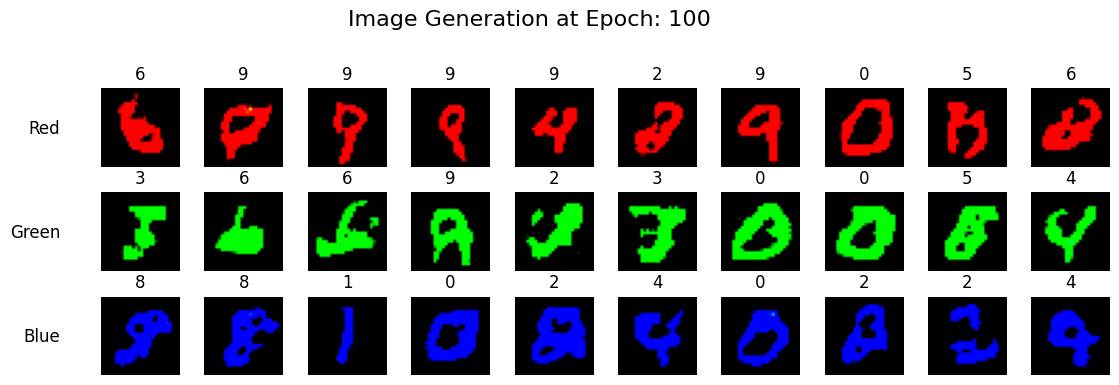

Epoch 100, Gen Loss: 0.8277, Disc Loss: 1.2940
Training finished.


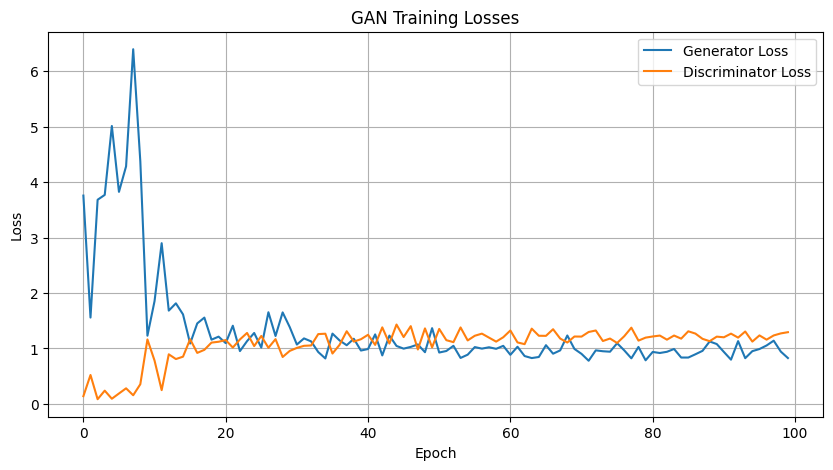


Generating final sample of images...


NameError: name 'generator' is not defined

In [5]:
# Train the generator (this will also trigger recognizer training if needed)
trained_generator = make_color_generator_model()
discriminator = make_color_discriminator_model()

g_losses, d_losses = train(trained_generator, discriminator)

# Plot the results
plot_losses(g_losses, d_losses)
print("\nGenerating final sample of images...")
generate_and_plot_final_images(trained_generator)

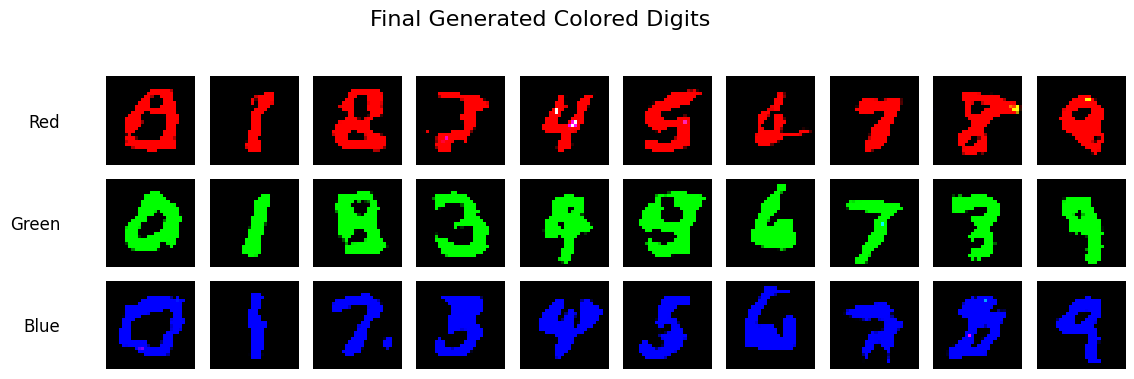

In [6]:
generate_and_plot_final_images(trained_generator)